In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from skimage.color import rgb2lab, lab2rgb
from matplotlib import patches as patch
from skimage import measure
from mpl_toolkits.mplot3d import Axes3D
import math
import tqdm
from numpy.linalg import inv, det
import scipy as sp
import seaborn as sns
from PIL import Image

%matplotlib inline



In [18]:
class GMM(object):
    def __init__(self, X, k=2):
        # dimension
        X = np.asarray(X)
        self.m, self.n = X.shape
        self.data = X.copy()
        # number of mixtures
        self.k = k
        
    def _init(self):
        # init mixture means/sigmas
        self.mean_arr = np.asmatrix(np.random.random((self.k, self.n)))
        self.sigma_arr = np.array([np.asmatrix(np.identity(self.n)) for i in range(self.k)])
        self.phi = np.ones(self.k)/self.k
        self.w = np.asmatrix(np.empty((self.m, self.k), dtype=float))
        #print(self.mean_arr)
        #print(self.sigma_arr)
    
    def fit(self, tol=1e-4):
        self._init()
        num_iters = 0
        ll = 1
        previous_ll = 0
        while(ll-previous_ll > tol):
            previous_ll = self.loglikelihood()
            self._fit()
            num_iters += 1
            ll = self.loglikelihood()
            print('Iteration %d: log-likelihood is %.6f'%(num_iters, ll))
        print('Terminate at %d-th iteration:log-likelihood is %.6f'%(num_iters, ll))
    
    def loglikelihood(self):
        ll = 0
        for i in range(self.m):
            tmp = 0
            for j in range(self.k):
                #print(self.sigma_arr[j])
                tmp += sp.stats.multivariate_normal.pdf(self.data[i, :], 
                                                        self.mean_arr[j, :].A1, 
                                                        self.sigma_arr[j, :]) *\
                       self.phi[j]
            ll += np.log(tmp) 
        return ll
    
    def _fit(self):
        self.e_step()
        self.m_step()
        
    def e_step(self):
        # calculate w_j^{(i)}
        for i in range(self.m):
            den = 0
            for j in range(self.k):
                num = sp.stats.multivariate_normal.pdf(self.data[i, :], 
                                                       self.mean_arr[j].A1, 
                                                       self.sigma_arr[j]) *\
                      self.phi[j]
                den += num
                self.w[i, j] = num
            self.w[i, :] /= den
            assert self.w[i, :].sum() - 1 < 1e-4
            
    def m_step(self):
        for j in range(self.k):
            const = self.w[:, j].sum()
            self.phi[j] = 1/self.m * const
            _mu_j = np.zeros(self.n)
            _sigma_j = np.zeros((self.n, self.n))
            for i in range(self.m):
                _mu_j += (self.data[i, :] * self.w[i, j])
                _sigma_j += self.w[i, j] * ((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
                #print((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
            self.mean_arr[j] = _mu_j / const
            self.sigma_arr[j] = _sigma_j / const

In [19]:
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

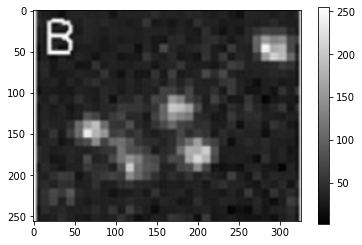

In [16]:
img = Image.open("Picture1.png")
gray_image=img.convert('L')
plt.imshow(gray_image, cmap = "gray")
plt.colorbar()

In [20]:
gmm = GMM(gray_image)
gmm.fit()

/var/folders/rk/gz59x8xx0bz69pn391mjkglw0000gn/T/ipykernel_32336/2037328255.py:42: RuntimeWarning: divide by zero encountered in log
  ll += np.log(tmp)
/var/folders/rk/gz59x8xx0bz69pn391mjkglw0000gn/T/ipykernel_32336/2037328255.py:60: RuntimeWarning: invalid value encountered in true_divide
  self.w[i, :] /= den


AssertionError: 

In [14]:
for i in range(326):

(256, 326, 4)

/var/folders/rk/gz59x8xx0bz69pn391mjkglw0000gn/T/ipykernel_32336/1334679046.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, bins = np.histogram(gray_image, bins = 300, normed = True)


Text(0.5, 0, 'a*')

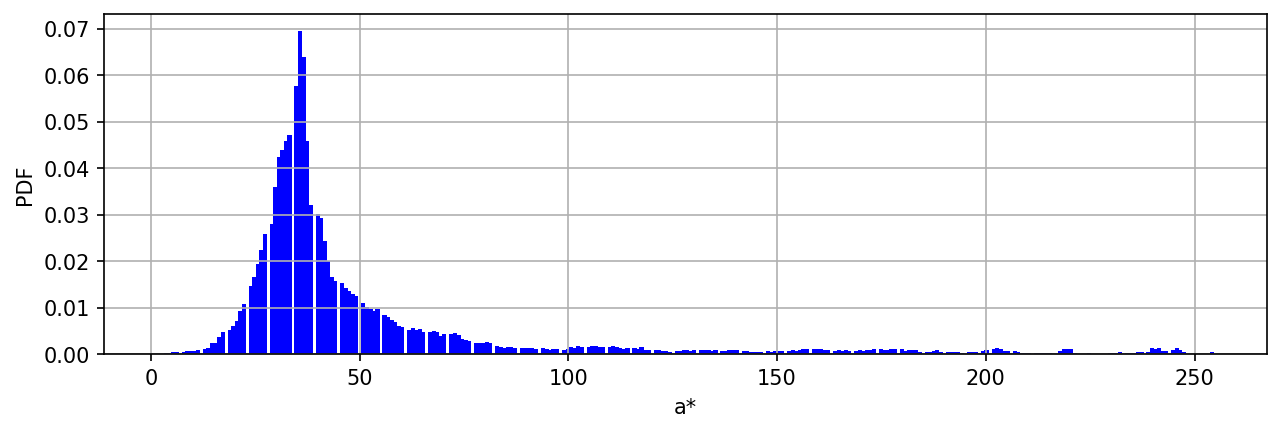

In [12]:
plt.figure(figsize = [10,3], dpi = 150)
plt.grid()
hist, bins = np.histogram(gray_image, bins = 300, normed = True)
plt.bar(bins[:-1], hist, width=1, color='b')
plt.ylabel("PDF")
plt.xlabel("a*")
plt.colorbar
# plt.xlim(-8,8)